In [17]:
import os
if os.environ.get("DISPLAY") is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: DISPLAY=:1


'bash' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

c:\users\yingg\desktop\myproject0\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


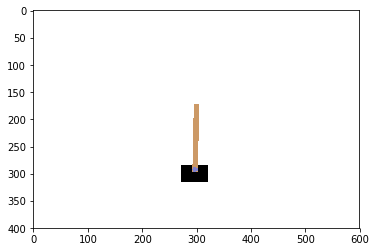

In [20]:
env = gym.make('CartPole-v0').env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render('rgb_array'))

In [21]:
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))
network.add(L.Dense(100,activation = 'relu'))
network.add(L.Dense(100,activation = 'relu'))
network.add(L.Dense(n_actions))

In [22]:
def get_action(state, epsilon=0):
    q_values = network.predict(state[None])[0]
    choice = np.random.random() > epsilon
    if choice:
        chosen_action = np.argmax(q_values)
    else: 
        chosen_action = np.random.choice(n_actions)
    return chosen_action

In [23]:
assert network.output_shape == (None, n_actions)
assert network.layers[-1].activation == keras.activations.linear

s = env.reset()
assert np.shape(get_action(s)) == ()
for eps in [0.,0.1,0.5,1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength = n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000* ( 1- eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


In [24]:
states_ph = tf.placeholder('float32', shape = (None,) + state_dim)
actions_ph = tf.placeholder('int32', shape = [None])
rewards_ph = tf.placeholder('float32', shape=[None])
next_states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
is_done_ph = tf.placeholder('bool', shape = [None])

In [25]:
predicted_qvalues = network(states_ph)
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis = 1)

In [26]:
gamma = 0.99
predicted_next_qvalues = network(next_states_ph)
next_state_values = tf.reduce_max(predicted_next_qvalues, axis = 1)
target_qvalues_for_actions = rewards_ph + gamma * next_state_values
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

In [27]:
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions))**2
loss = tf.reduce_mean(loss)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [28]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

In [35]:
def generate_session(t_max=1000, epsilon=0, train=False):
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph :[a], rewards_ph: [r],
                next_states_ph:[next_s], is_done_ph: [done]
            })
            
        total_reward += r
        s = next_s
        if done: break
    return total_reward

In [36]:
epsilon = 0.5

In [37]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print('epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}'.format(i,np.mean(session_rewards),epsilon))
    
    epsilon *=0.99
    assert epsilon >= 1e-4, ' Make sure epsilon is always nonzero during training'
    if np.mean(session_rewards) > 300:
        print('You win!')
        break

epoch #0	mean reward = 13.760	epsilon = 0.500
epoch #1	mean reward = 14.430	epsilon = 0.495
epoch #2	mean reward = 13.560	epsilon = 0.490
epoch #3	mean reward = 15.400	epsilon = 0.485
epoch #4	mean reward = 13.250	epsilon = 0.480
epoch #5	mean reward = 13.330	epsilon = 0.475
epoch #6	mean reward = 17.130	epsilon = 0.471
epoch #7	mean reward = 15.170	epsilon = 0.466
epoch #8	mean reward = 14.570	epsilon = 0.461
epoch #9	mean reward = 16.510	epsilon = 0.457
epoch #10	mean reward = 19.540	epsilon = 0.452
epoch #11	mean reward = 19.680	epsilon = 0.448
epoch #12	mean reward = 21.190	epsilon = 0.443
epoch #13	mean reward = 37.490	epsilon = 0.439
epoch #14	mean reward = 51.190	epsilon = 0.434
epoch #15	mean reward = 39.450	epsilon = 0.430
epoch #16	mean reward = 58.290	epsilon = 0.426
epoch #17	mean reward = 65.200	epsilon = 0.421
epoch #18	mean reward = 104.810	epsilon = 0.417
epoch #19	mean reward = 116.690	epsilon = 0.413
epoch #20	mean reward = 138.890	epsilon = 0.409
epoch #21	mean rewar